<a href="https://colab.research.google.com/github/akbarjon2000/DataScience/blob/main/Random_Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from matplotlib import colors
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import ListedColormap
from sklearn import metrics
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
np.random.seed(42)

In [7]:
#Loading the dataset
data = pd.read_csv("/content/Customer marketing.csv", sep="\t")
print("Number of datapoints:", len(data))
data.head()

Number of datapoints: 2240


,ID_,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Information on features
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID_                  2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

In [8]:
#To remove the NA values
data = data.dropna()
print("The total number of data-points after removing the rows with missing values are:", len(data))

The total number of data-points after removing the rows with missing values are: 2216


In [9]:

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"], format="%d-%m-%Y")

dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)
#Dates of the newest and oldest recorded customer
print("The newest customer's enrolment date in therecords:",max(dates))
print("The oldest customer's enrolment date in the records:",min(dates))

The newest customer's enrolment date in therecords: 2014-06-29
The oldest customer's enrolment date in the records: 2012-07-30


In [10]:
#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

In [ ]:


print("Total categories in the feature Marital_Status:\n", data["Marital_Status"].value_counts(), "\n")
print("Total categories in the feature Education:\n", data["Education"].value_counts())

Total categories in the feature Marital_Status:
 Marital_Status
Married     857
Together    573
Single      471
Divorced    232
Widow        76
Alone         3
Absurd        2
YOLO          2
Name: count, dtype: int64 

Total categories in the feature Education:
 Education
Graduation    1116
PhD            481
Master         365
2n Cycle       200
Basic           54
Name: count, dtype: int64


In [11]:
# Check available columns
print("Columns in DataFrame:", data.columns.tolist())

# Initialize the list of spending columns
spending_columns = ["MntWines", "MntFruits", "MntMeatProducts", "MntFishProducts", "MntSweetProducts", "MntGoldProds"]

# Check which spending columns exist in the DataFrame
existing_spending_columns = [col for col in spending_columns if col in data.columns]

# If any spending columns exist, sum them
if existing_spending_columns:
    data["Spent"] = data[existing_spending_columns].sum(axis=1)
else:
    print("No spending columns found in DataFrame.")

# Age of customer today
if 'Year_Birth' in data.columns:
    data["Age"] = 2021 - data["Year_Birth"]

# Deriving living situation by marital status "Alone"
if 'Marital_Status' in data.columns:
    data["Living_With"] = data["Marital_Status"].replace({
        "Married": "Partner",
        "Together": "Partner",
        "Absurd": "Alone",
        "Widow": "Alone",
        "YOLO": "Alone",
        "Divorced": "Alone",
        "Single": "Alone"
    })

# Feature indicating total children living in the household
if 'Kidhome' in data.columns and 'Teenhome' in data.columns:
    data["Children"] = data["Kidhome"].fillna(0) + data["Teenhome"].fillna(0)
else:
    print("Kidhome or Teenhome column is missing.")

# Feature for total members in the household
if 'Living_With' in data.columns:
    data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner": 2}).fillna(0) + data.get("Children", 0)

# Feature pertaining to parenthood
if 'Children' in data.columns:
    data["Is_Parent"] = np.where(data["Children"] > 0, 1, 0)

# Segmenting education levels into three groups
if 'Education' in data.columns:
    data["Education"] = data["Education"].replace({
        "Basic": "Undergraduate",
        "2n Cycle": "Undergraduate",
        "Graduation": "Graduate",
        "Master": "Postgraduate",
        "PhD": "Postgraduate"
    })

# For clarity: renaming columns
rename_dict = {
    "MntWines": "Wines",
    "MntFruits": "Fruits",
    "MntMeatProducts": "Meat",
    "MntFishProducts": "Fish",
    "MntSweetProducts": "Sweets",
    "MntGoldProds": "Gold"
}

# Only rename columns that exist in the DataFrame
data.rename(columns={k: v for k, v in rename_dict.items() if k in data.columns}, inplace=True)

# Dropping some of the redundant features, checking for existence first
to_drop = ["Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID"]
data = data.drop(columns=data.columns.intersection(to_drop), errors='ignore')  # Ignore missing columns

# Output the final DataFrame shape and first few rows for verification
print("Final DataFrame shape:", data.shape)
print(data.head())


Columns in DataFrame: ['ID_', 'Year_Birth', 'Education', 'Marital_Status', 'Income', 'Kidhome', 'Teenhome', 'Dt_Customer', 'Recency', 'MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1', 'AcceptedCmp2', 'Complain', 'Z_CostContact', 'Z_Revenue', 'Response', 'Customer_For']
Final DataFrame shape: (2216, 31)
    ID_     Education   Income  Kidhome  Teenhome  Recency  Wines  Fruits  \
0  5524      Graduate  58138.0        0         0       58    635      88   
1  2174      Graduate  46344.0        1         1       38     11       1   
2  4141      Graduate  71613.0        0         0       26    426      49   
3  6182      Graduate  26646.0        1         0       26     11       4   
4  5324  Postgraduate  58293.0        1         0       94    173      43   

   Meat  Fish  

<ipython-input-11-c912469aa3ae>:40: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner": 2}).fillna(0) + data.get("Children", 0)


In [12]:

data.describe()

,ID_,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,Sweets,...,AcceptedCmp1,AcceptedCmp2,Complain,Response,Customer_For,Spent,Age,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,...,2216.000000,2216.000000,2216.000000,2216.000000,2.216000e+03,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,5588.353339,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,...,0.064079,0.013538,0.009477,0.150271,3.054423e+16,607.075361,52.179603,0.947202,2.592509,0.714350
std,3249.376275,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,...,0.244950,0.115588,0.096907,0.357417,1.749036e+16,602.900476,11.985554,0.749062,0.905722,0.451825
min,0.000000,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000e+00,5.000000,25.000000,0.000000,1.000000,0.000000
25%,2814.750000,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.555200e+16,69.000000,44.000000,0.000000,2.000000,0.000000
50%,5458.500000,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,...,0.000000,0.000000,0.000000,0.000000,3.071520e+16,396.500000,51.000000,1.000000,3.000000,1.000000
75%,8421.750000,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,...,0.000000,0.000000,0.000000,0.000000,4.570560e+16,1048.000000,62.000000,1.000000,3.000000,1.000000
max,11191.000000,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,...,1.000000,1.000000,1.000000,1.000000,6.039360e+16,2525.000000,128.000000,3.000000,5.000000,1.000000


Reletive Plot Of Some Selected Features: A Data Subset


<Figure size 800x550 with 0 Axes>

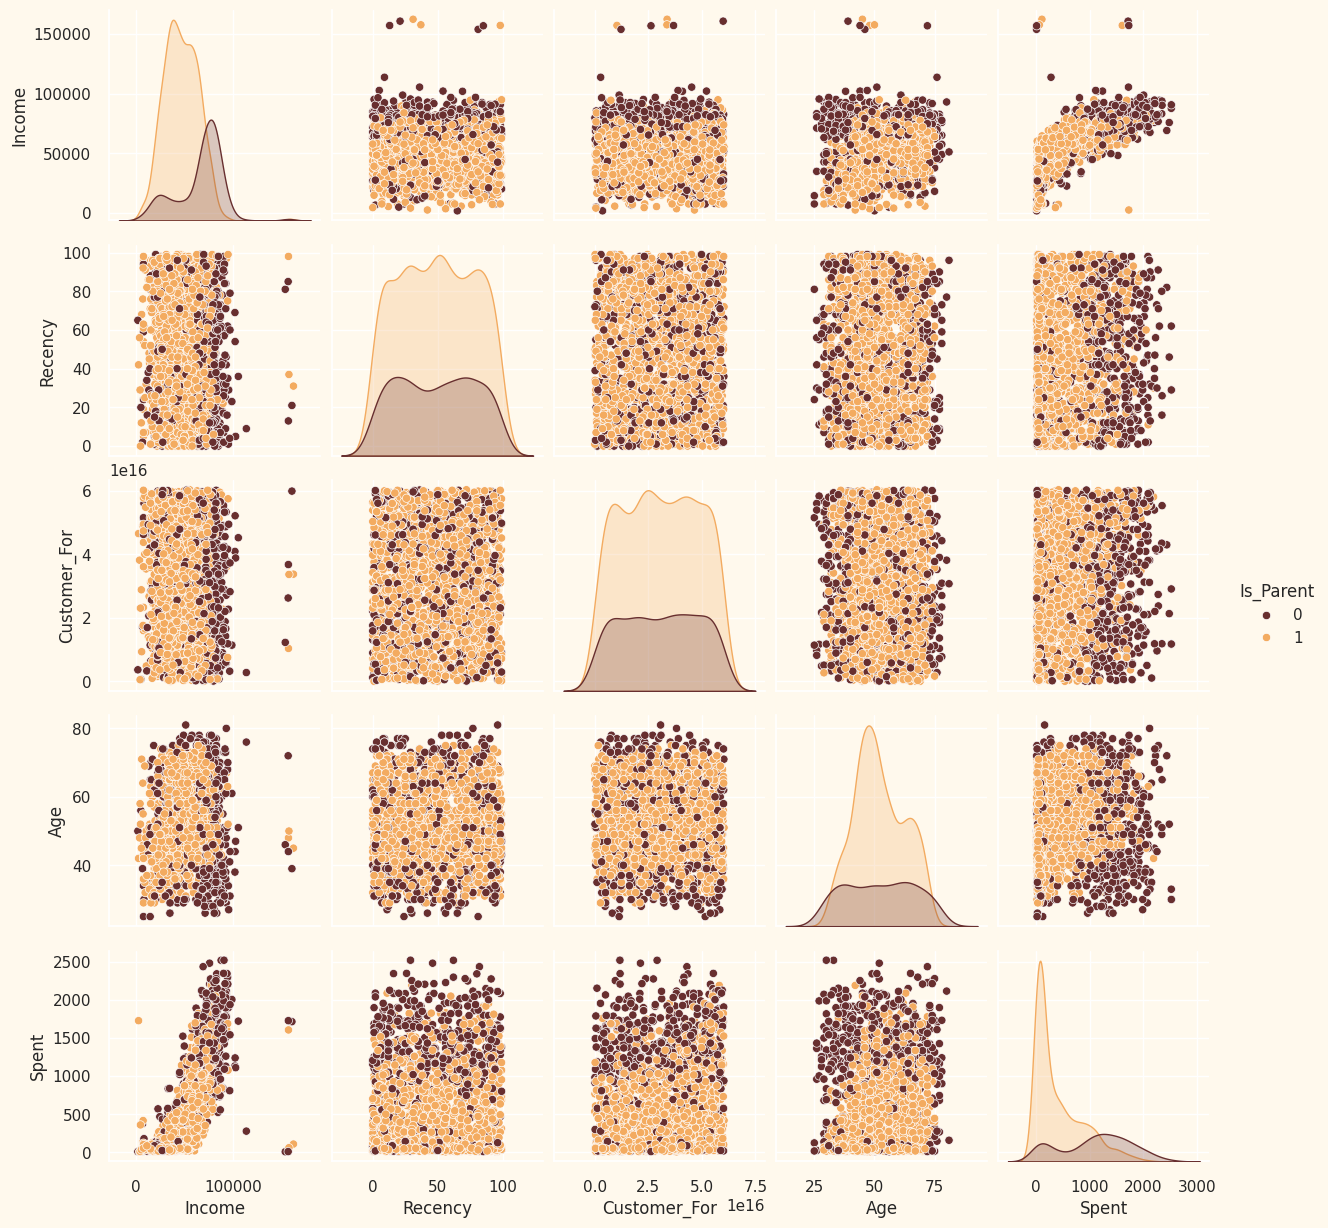

In [25]:
#To plot some selected features
#Setting up colors prefrences
sns.set(rc={"axes.facecolor":"#FFF9ED","figure.facecolor":"#FFF9ED"})
pallet = ["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"]
cmap = colors.ListedColormap(["#682F2F", "#9E726F", "#D6B2B1", "#B9C0C9", "#9F8A78", "#F3AB60"])
#Plotting following features
To_Plot = [ "Income", "Recency", "Customer_For", "Age", "Spent", "Is_Parent"]
print("Reletive Plot Of Some Selected Features: A Data Subset")
plt.figure()
sns.pairplot(data[To_Plot], hue= "Is_Parent",palette= (["#682F2F","#F3AB60"]))
#Taking hue
plt.show()

In [13]:
#Dropping the outliers by setting a cap on Age and income.
data = data[(data["Age"]<90)]
data = data[(data["Income"]<600000)]
print("The total number of data-points after removing the outliers are:", len(data))

The total number of data-points after removing the outliers are: 2212


Data types before processing:
ID_                      int64
Education                int64
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
Wines                    int64
Fruits                   int64
Meat                     int64
Fish                     int64
Sweets                   int64
Gold                     int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
Customer_For             int64
Spent                    int64
Age                      int64
Living_With              int64
Children                 int64
Family_Size              int64
Is_Parent                int64
Clusters 

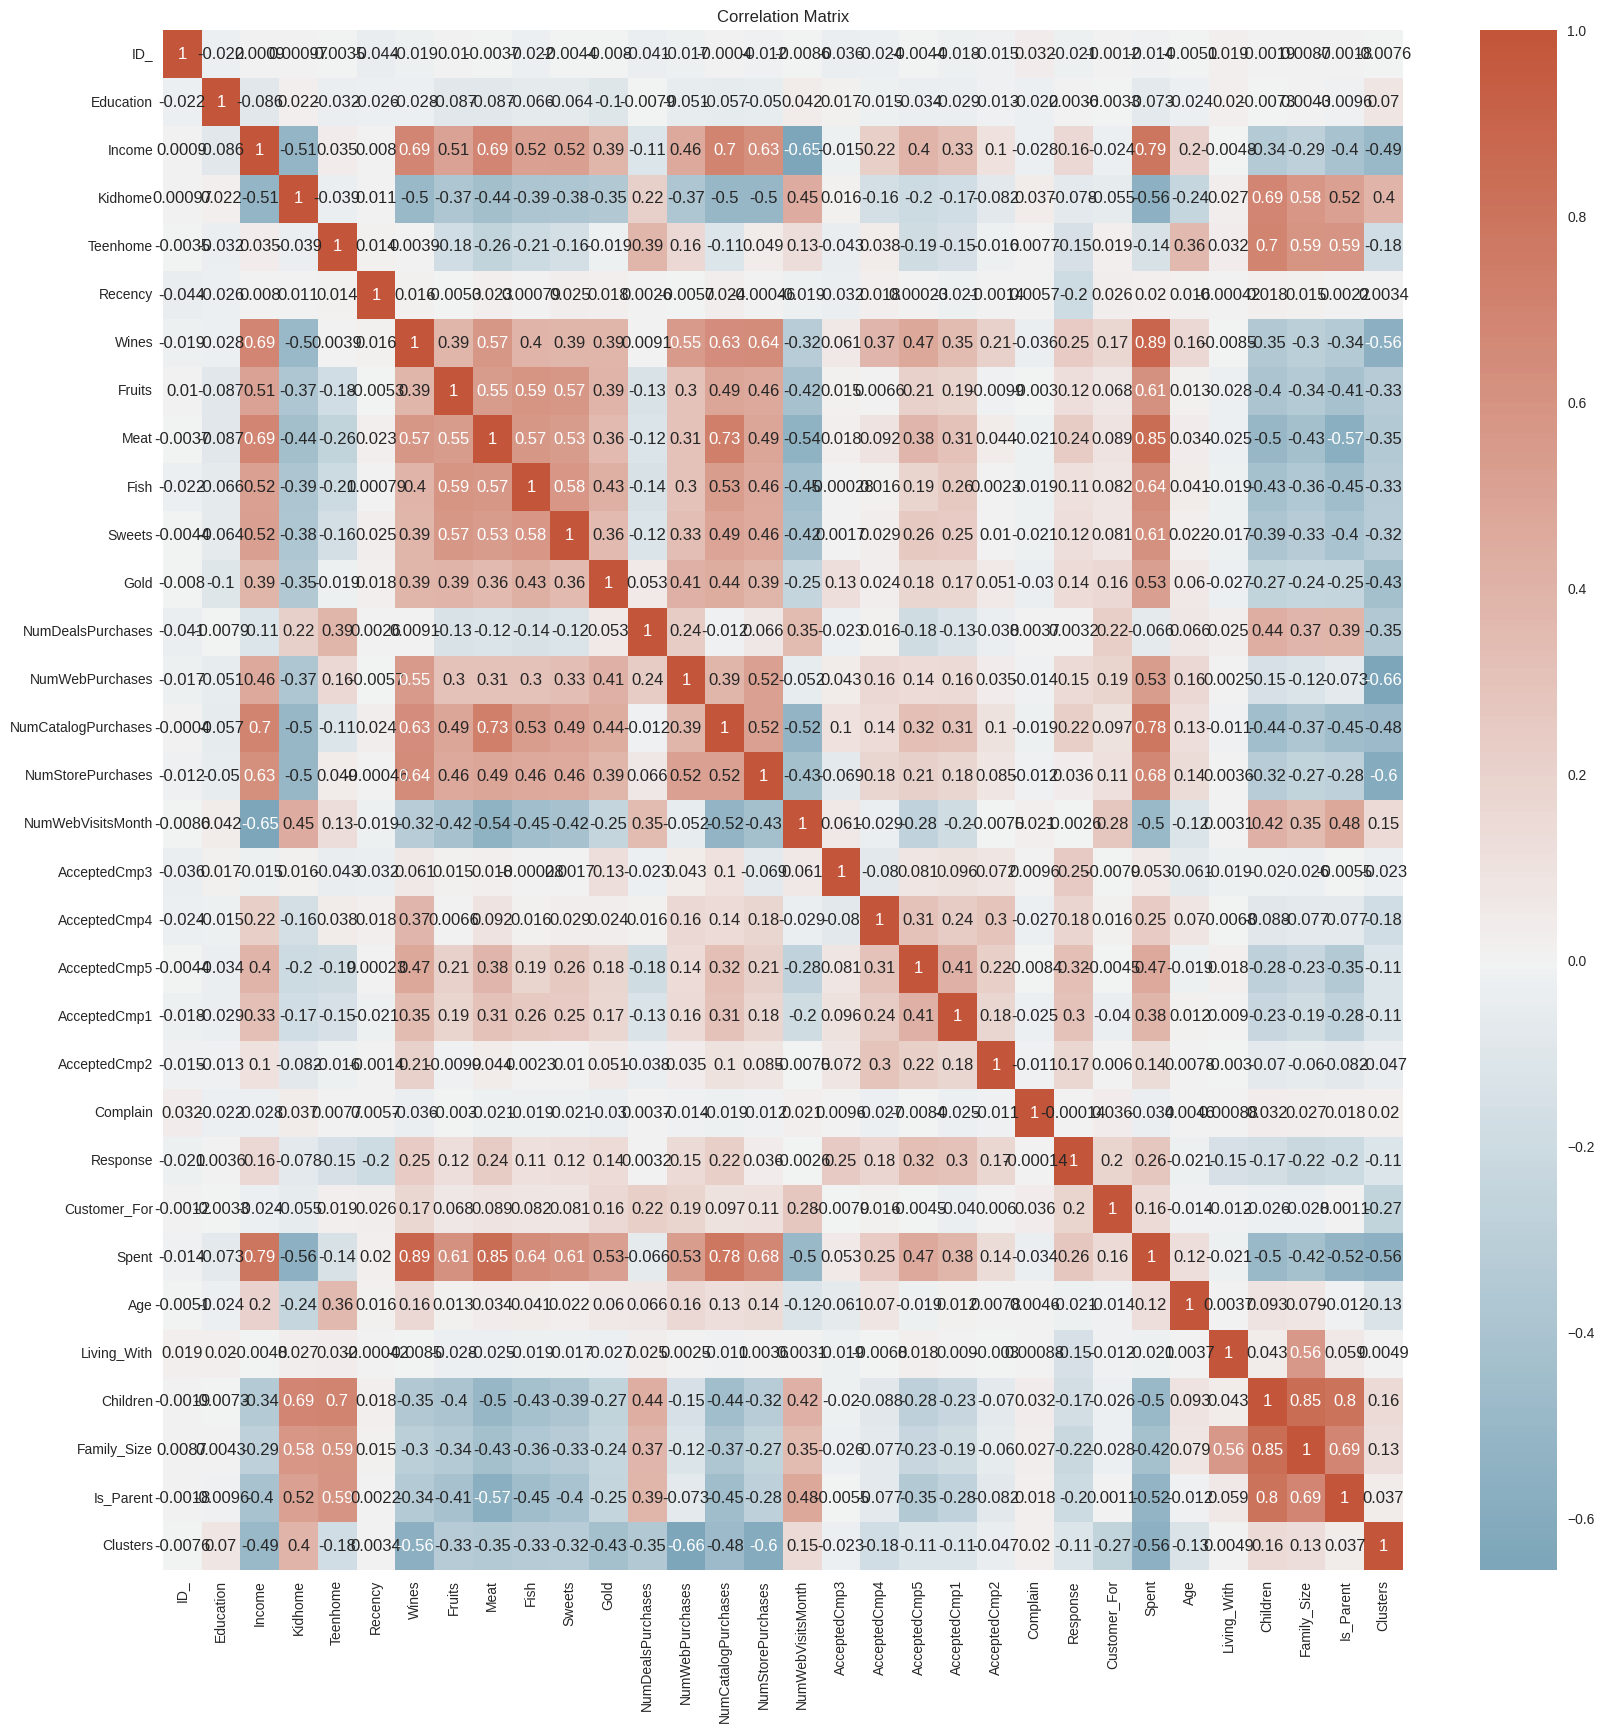

In [24]:
# Assuming 'data' is your DataFrame
# Check the data types of the columns
print("Data types before processing:")
print(data.dtypes)

# Convert categorical variables to numerical using label encoding if needed
# For example, convert 'Education' into numeric categories
if 'Education' in data.columns:
    data['Education'] = data['Education'].astype('category').cat.codes

# Optionally, convert other categorical columns (if necessary)
# List any other categorical columns you want to convert here
categorical_columns = ['Living_With']  # Add any other categorical columns as needed
for col in categorical_columns:
    if col in data.columns:
        data[col] = data[col].astype('category').cat.codes

# Now check the data types again
print("Data types after processing:")
print(data.dtypes)

# Calculate the correlation matrix
corrmat = data.corr()

# Visualize the correlation matrix
plt.figure(figsize=(20, 20))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corrmat, annot=True, cmap=cmap, center=0)
plt.title("Correlation Matrix")
plt.show()

In [14]:
#Get list of categorical variables
s = (data.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Education', 'Living_With']


In [15]:
#Label Encoding the object dtypes.
LE=LabelEncoder()
for i in object_cols:
    data[i]=data[[i]].apply(LE.fit_transform)

print("All features are now numerical")

All features are now numerical


In [16]:


#Creating a copy of data
ds = data.copy()
# creating a subset of dataframe by dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'AcceptedCmp1','AcceptedCmp2', 'Complain', 'Response']
ds = ds.drop(cols_del, axis=1)
#Scaling
scaler = StandardScaler()
scaler.fit(ds)
scaled_ds = pd.DataFrame(scaler.transform(ds),columns= ds.columns )
print("All features are now scaled")

All features are now scaled


In [17]:
#Scaled data to be used for reducing the dimensionality
print("Dataframe to be used for further modelling:")
scaled_ds.head()

Dataframe to be used for further modelling:


,ID_,Education,Income,Kidhome,Teenhome,Recency,Wines,Fruits,Meat,Fish,...,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Customer_For,Spent,Age,Living_With,Children,Family_Size,Is_Parent
0,-0.018837,-0.893586,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,...,2.503607,-0.555814,0.692181,1.527721,1.676245,1.018352,-1.349603,-1.264598,-1.758359,-1.581139
1,-1.050626,-0.893586,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,...,-0.571340,-1.171160,-0.132545,-1.189011,-0.963297,1.274785,-1.349603,1.404572,0.449070,0.632456
2,-0.444797,-0.893586,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,...,-0.229679,1.290224,-0.544908,-0.206048,0.280110,0.334530,0.740959,-1.264598,-0.654644,-1.581139
3,0.183824,-0.893586,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,...,-0.913000,-0.555814,0.279818,-1.060584,-0.920135,-1.289547,0.740959,0.069987,0.449070,0.632456
4,-0.080437,0.571657,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,...,0.111982,0.059532,-0.132545,-0.951915,-0.307562,-1.033114,0.740959,0.069987,0.449070,0.632456


In [18]:


#Initiating PCA to reduce dimentions aka features to 3
pca = PCA(n_components=3)
pca.fit(scaled_ds)
PCA_ds = pd.DataFrame(pca.transform(scaled_ds), columns=(["col1","col2", "col3"]))
PCA_ds.describe().T

,count,mean,std,min,25%,50%,75%,max
col1,2212.0,-1.092154e-16,2.878610,-5.981310,-2.540562,-0.782426,2.386105,7.452993
col2,2212.0,6.424437e-18,1.709592,-4.206238,-1.329272,-0.168563,1.223445,6.166002
col3,2212.0,-1.164429e-17,1.232372,-3.703483,-0.854724,-0.057465,0.853258,6.658018


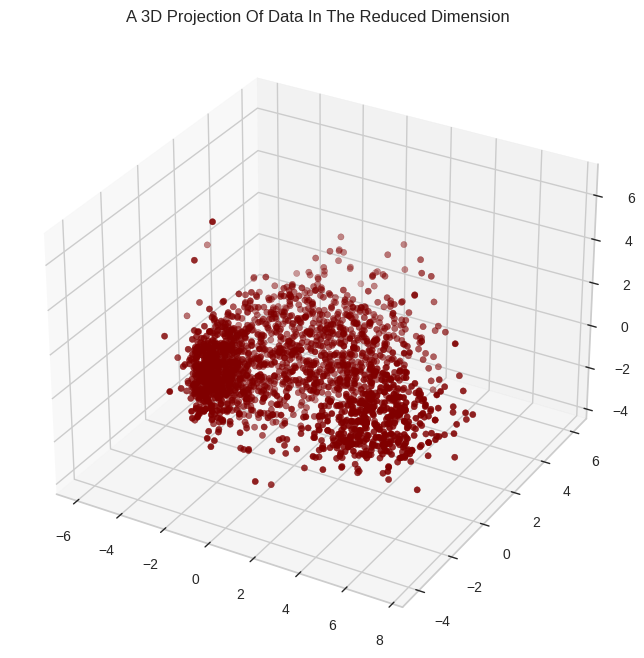

In [19]:
#A 3D Projection Of Data In The Reduced Dimension
x =PCA_ds["col1"]
y =PCA_ds["col2"]
z =PCA_ds["col3"]
#To plot
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(x,y,z, c="maroon", marker="o" )
ax.set_title("A 3D Projection Of Data In The Reduced Dimension")
plt.show()

Elbow Method to determine the number of clusters to be formed:


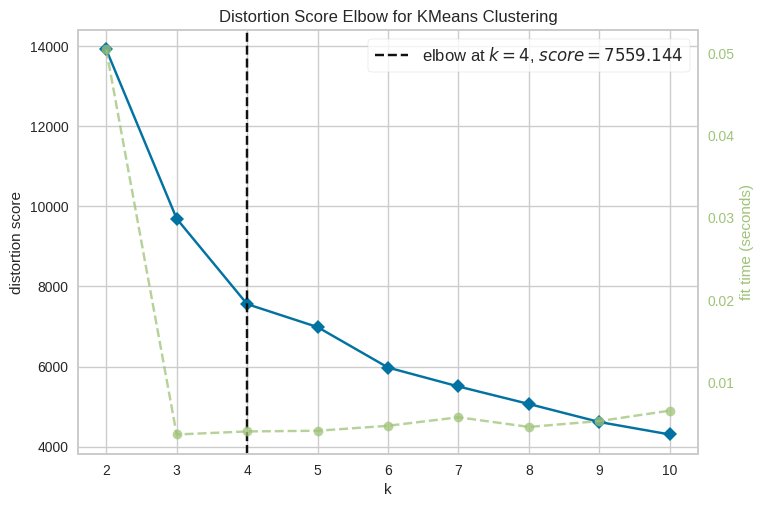

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [20]:
# Quick examination of elbow method to find numbers of clusters to make.
print('Elbow Method to determine the number of clusters to be formed:')
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(PCA_ds)
Elbow_M.show()

In [21]:
#Initiating the Agglomerative Clustering model
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(PCA_ds)
PCA_ds["Clusters"] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data["Clusters"]= yhat_AC

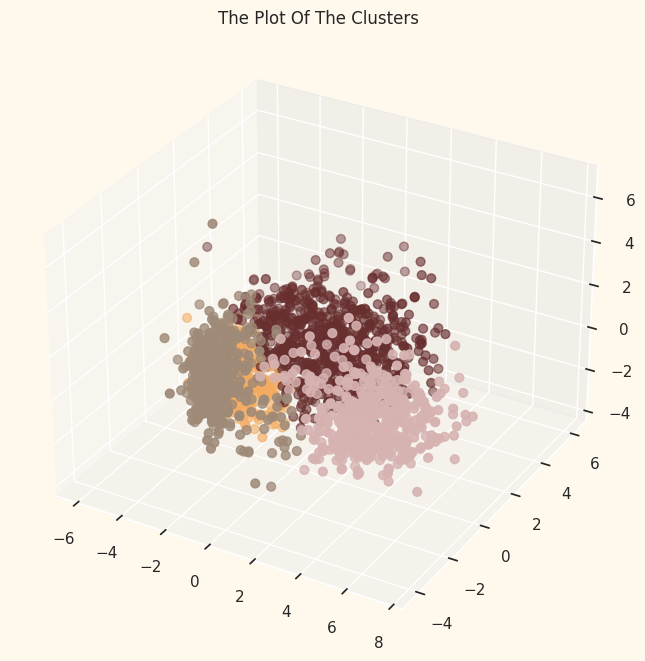

In [27]:
#Plotting the clusters
fig = plt.figure(figsize=(10,8))
ax = plt.subplot(111, projection='3d', label="bla")
ax.scatter(x, y, z, s=40, c=PCA_ds["Clusters"], marker='o', cmap = cmap )
ax.set_title("The Plot Of The Clusters")
plt.show()

<ipython-input-28-2f63248a592e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl = sns.countplot(x=data["Clusters"], palette= pal)


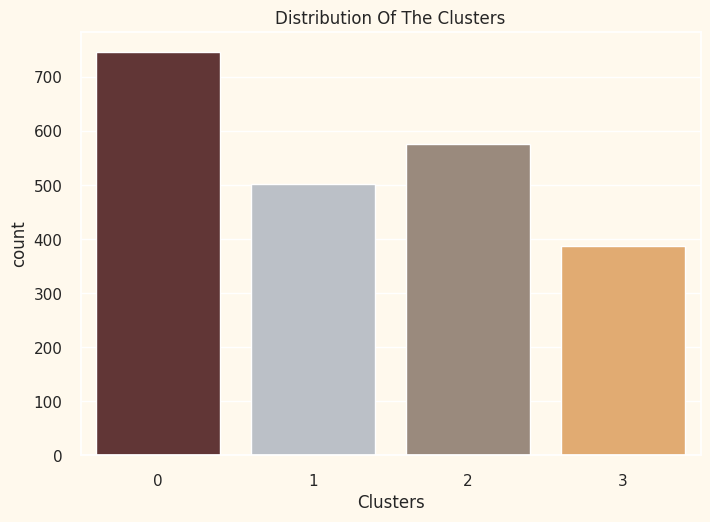

In [28]:
#Plotting countplot of clusters
pal = ["#682F2F","#B9C0C9", "#9F8A78","#F3AB60"]
pl = sns.countplot(x=data["Clusters"], palette= pal)
pl.set_title("Distribution Of The Clusters")
plt.show()

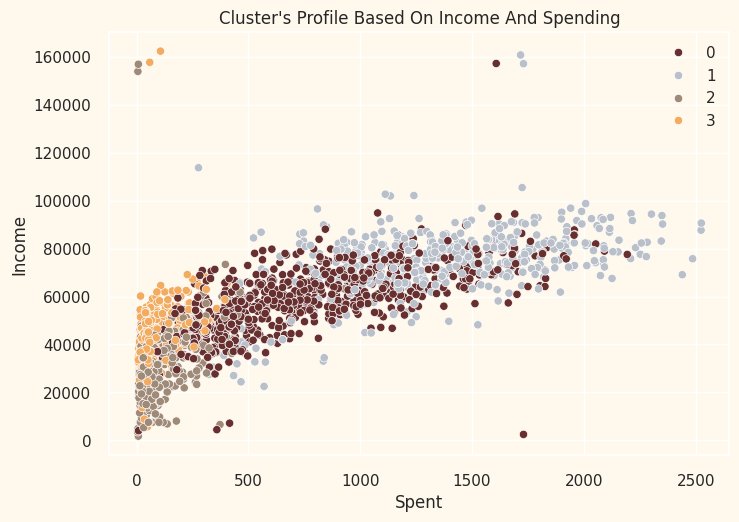

In [29]:

pl = sns.scatterplot(data = data,x=data["Spent"], y=data["Income"],hue=data["Clusters"], palette= pal)
pl.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 21.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 71.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:3399: UserWarning: 63.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
<ipython-input-30-b5a4c0fdc6d1>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
/usr/local/lib/python3.10/dist-packages/seaborn/ca

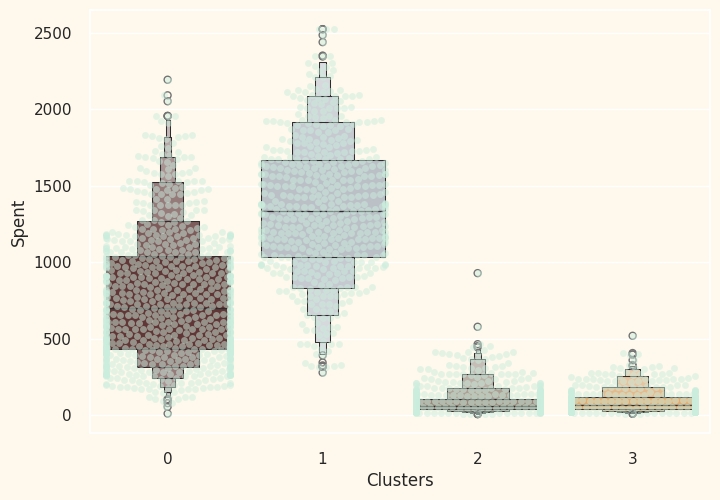

In [30]:
plt.figure()
pl=sns.swarmplot(x=data["Clusters"], y=data["Spent"], color= "#CBEDDD", alpha=0.5 )
pl=sns.boxenplot(x=data["Clusters"], y=data["Spent"], palette=pal)
plt.show()

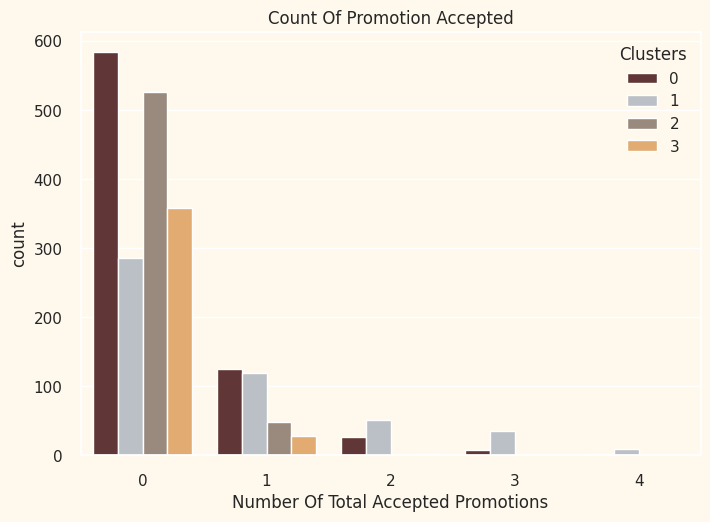

In [31]:
#Creating a feature to get a sum of accepted promotions
data["Total_Promos"] = data["AcceptedCmp1"]+ data["AcceptedCmp2"]+ data["AcceptedCmp3"]+ data["AcceptedCmp4"]+ data["AcceptedCmp5"]
#Plotting count of total campaign accepted.
plt.figure()
pl = sns.countplot(x=data["Total_Promos"],hue=data["Clusters"], palette= pal)
pl.set_title("Count Of Promotion Accepted")
pl.set_xlabel("Number Of Total Accepted Promotions")
plt.show()

<ipython-input-32-0ef84d1c8fe9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)


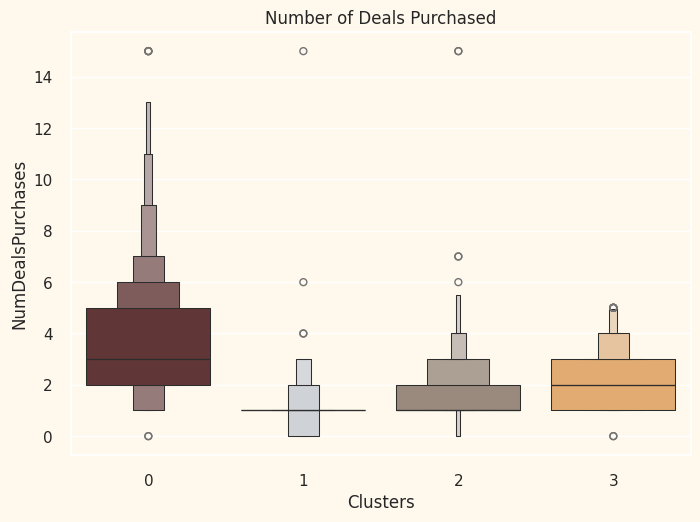

In [32]:


#Plotting the number of deals purchased
plt.figure()
pl=sns.boxenplot(y=data["NumDealsPurchases"],x=data["Clusters"], palette= pal)
pl.set_title("Number of Deals Purchased")
plt.show()

In [33]:
# Updated feature list based on the DataFrame columns
features = ['Income', 'Recency', 'Wines', 'Fruits', 'Meat',
            'Fish', 'Sweets', 'Gold',
            'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases',
            'NumStorePurchases', 'NumWebVisitsMonth', 'Kidhome', 'Teenhome']


In [34]:
scaler = StandardScaler()

In [35]:
scaled_ds['Income'].fillna(scaled_ds['Income'].mean(), inplace=True)

<ipython-input-35-4afd672dd586>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  scaled_ds['Income'].fillna(scaled_ds['Income'].mean(), inplace=True)


In [36]:
scaled_data = scaler.fit_transform(scaled_ds[features])

In [37]:
print(scaled_ds.columns)

Index(['ID_', 'Education', 'Income', 'Kidhome', 'Teenhome', 'Recency', 'Wines',
       'Fruits', 'Meat', 'Fish', 'Sweets', 'Gold', 'NumDealsPurchases',
       'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
       'NumWebVisitsMonth', 'Customer_For', 'Spent', 'Age', 'Living_With',
       'Children', 'Family_Size', 'Is_Parent'],
      dtype='object')


In [38]:
pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

In [39]:
k = 5  # example number
kmeans = KMeans(n_clusters=k, random_state=0)
clusters = kmeans.fit_predict(scaled_data)
data['Cluster'] = clusters

In [41]:
# Step 2: Analyze Spending Patterns in Each Cluster
cluster_summary = data.groupby('Cluster')[['Wines', 'Fruits', 'Meat',
                                           'Fish', 'Sweets', 'Gold']].mean()


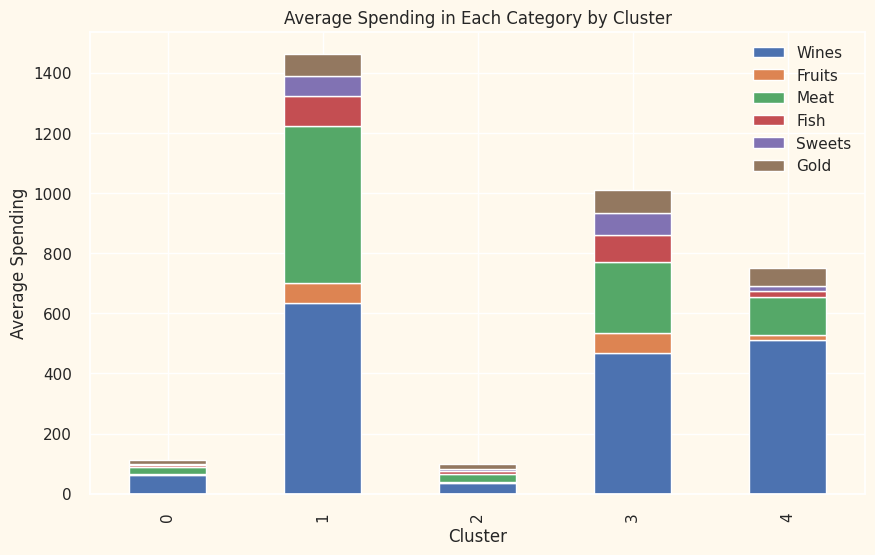

In [42]:

# Optional: Visualize spending patterns by cluster
cluster_summary.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Average Spending in Each Category by Cluster')
plt.ylabel('Average Spending')
plt.xlabel('Cluster')
plt.show()


In [43]:

# Step 3: Predictive Model for Future Category Prediction
X = data[features]  # input features
y = data['Cluster']  # target is cluster (segmentation by behavior)

In [46]:
# Split data for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
# Train a random forest classifier to predict cluster (behaviors)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [50]:
data['PredictedCluster'] = rf.predict(X)

In [51]:
y_pred = rf.predict(X_test)


In [52]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy * 100:.2f}%")


Accuracy: 93.45%


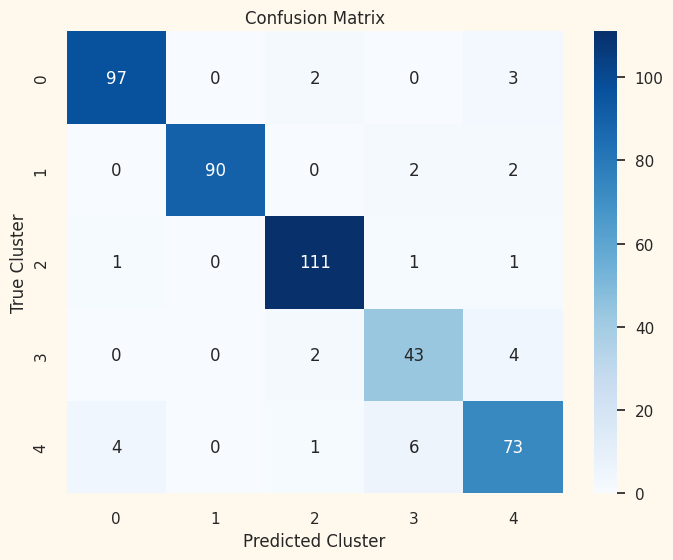

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel("Predicted Cluster")
plt.ylabel("True Cluster")
plt.title("Confusion Matrix")
plt.show()


In [54]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.95      0.95      0.95       102
           1       1.00      0.96      0.98        94
           2       0.96      0.97      0.97       114
           3       0.83      0.88      0.85        49
           4       0.88      0.87      0.87        84

    accuracy                           0.93       443
   macro avg       0.92      0.93      0.92       443
weighted avg       0.94      0.93      0.93       443



In [55]:
new_customer = pd.DataFrame({
    'Income': [50000],          # example income
    'Recency': [10],            # days since last purchase
    'Wines': [100],             # previous spending on wines
    'Fruits': [20],             # previous spending on fruits
    'Meat': [150],              # previous spending on meat
    'Fish': [30],               # previous spending on fish
    'Sweets': [10],             # previous spending on sweets
    'Gold': [40],               # previous spending on gold products
    'NumDealsPurchases': [5],
    'NumWebPurchases': [3],
    'NumCatalogPurchases': [1],
    'NumStorePurchases': [8],
    'NumWebVisitsMonth': [4],
    'Kidhome': [1],
    'Teenhome': [0]
})

In [56]:
# Scale the new customer's data using the same scaler as before
new_customer_scaled = scaler.transform(new_customer)

# Predict the cluster for the new customer
predicted_cluster = rf.predict(new_customer_scaled)
print(f"Predicted Cluster: {predicted_cluster[0]}")

Predicted Cluster: 2


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [57]:
# Get the spending profile for the predicted cluster
cluster_profile = cluster_summary.loc[predicted_cluster[0]]

# Recommend products based on spending patterns (e.g., higher average spending in certain categories)
recommended_products = cluster_profile.sort_values(ascending=False).head(3)  # top 3 categories
print("Recommended products and categories:")
print(recommended_products)


Recommended products and categories:
Wines    33.767521
Meat     25.800000
Gold     17.598291
Name: 2, dtype: float64
